In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import options, index and rates data

In [2]:
# import options data
data = pd.read_csv("NDXP.csv").sort_values(by=['quote_date', 'strike']).reset_index(drop = True)
data['quote_date'] = pd.to_datetime(data['quote_date'])
data['expiration'] = pd.to_datetime(data['expiration'])
data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-04,2018-02-02,6200.0,C,401.9,423.0
1,2018-01-04,2018-02-02,6200.0,P,11.8,16.0
2,2018-01-04,2018-02-09,6200.0,C,406.2,427.0
3,2018-01-04,2018-02-09,6200.0,P,18.7,23.0
4,2018-01-04,2018-02-23,6200.0,C,417.5,439.0
...,...,...,...,...,...,...
7226456,2022-12-30,2023-01-06,16000.0,P,5106.0,5122.1
7226457,2022-12-30,2023-01-13,16000.0,C,0.0,0.9
7226458,2022-12-30,2023-01-13,16000.0,P,5089.8,5106.2
7226459,2022-12-30,2023-01-27,16000.0,C,0.0,1.2


In [3]:
NDX_100 = pd.read_csv('NDX100_Data.csv')
NDX_100.rename(columns = {'Close/Last':'NDX_Exp'}, inplace = True)
NDX_100['Date'] = pd.to_datetime(NDX_100['Date'])
NDX_100

,Date,NDX_Exp
0,2024-01-05,16305.98
1,2024-01-04,16282.01
2,2024-01-03,16368.49
3,2024-01-02,16543.94
4,2023-12-29,16825.93
...,...,...
2530,2014-01-10,3565.08
2531,2014-01-09,3552.58
2532,2014-01-08,3567.54
2533,2014-01-07,3557.85


In [4]:
# import interest rate data
rates = pd.read_csv("DGS1MO.csv").ffill()
rates.replace('.', pd.NA, inplace=True)
rates.columns = ['date','rate']
rates['date'] = pd.to_datetime(rates['date'])
rates['rate'] = (pd.to_numeric(rates['rate'])/100).fillna(method='ffill')
rates

,date,rate
0,2018-01-02,0.0129
1,2018-01-03,0.0129
2,2018-01-04,0.0128
3,2018-01-05,0.0127
4,2018-01-08,0.0130
...,...,...
1299,2022-12-26,0.0380
1300,2022-12-27,0.0387
1301,2022-12-28,0.0386
1302,2022-12-29,0.0404


## Filter second fridays, (and thursdays if fridays don't exist)

In [5]:
# second fridays between 2018 and 2022

all_fridays = pd.date_range(start="2018-01-01", end="2022-12-31", freq='W-FRI') ## all fridays in the period

second_fridays = [] # initialize second fridays list

for friday in all_fridays: # loop through every friday and determine if it is second friday
    month_start = pd.offsets.MonthBegin(1) # create a date offset to move friday to start of the month
    if len(pd.date_range(start = friday - month_start, end = friday, freq='W-FRI')) == 2: # if number of fridays since start of month is 2:
        second_fridays.append(friday)

second_fridays = pd.Series(second_fridays)
old_date = pd.to_datetime('2020-04-10') # replace missing friday with thursday
new_date = pd.to_datetime('2020-04-09')
index = second_fridays[second_fridays == old_date].index
second_fridays.at[index[0]] = new_date
second_fridays

0    2018-01-12
1    2018-02-09
2    2018-03-09
3    2018-04-13
4    2018-05-11
5    2018-06-08
6    2018-07-13
7    2018-08-10
8    2018-09-14
9    2018-10-12
10   2018-11-09
11   2018-12-14
12   2019-01-11
13   2019-02-08
14   2019-03-08
15   2019-04-12
16   2019-05-10
17   2019-06-14
18   2019-07-12
19   2019-08-09
20   2019-09-13
21   2019-10-11
22   2019-11-08
23   2019-12-13
24   2020-01-10
25   2020-02-14
26   2020-03-13
27   2020-04-09
28   2020-05-08
29   2020-06-12
30   2020-07-10
31   2020-08-14
32   2020-09-11
33   2020-10-09
34   2020-11-13
35   2020-12-11
36   2021-01-08
37   2021-02-12
38   2021-03-12
39   2021-04-09
40   2021-05-14
41   2021-06-11
42   2021-07-09
43   2021-08-13
44   2021-09-10
45   2021-10-08
46   2021-11-12
47   2021-12-10
48   2022-01-14
49   2022-02-11
50   2022-03-11
51   2022-04-08
52   2022-05-13
53   2022-06-10
54   2022-07-08
55   2022-08-12
56   2022-09-09
57   2022-10-14
58   2022-11-11
59   2022-12-09
dtype: datetime64[ns]

In [6]:
# get second-friday expirations
second_friday_exp = data[data['expiration'].isin(second_fridays)]
day_difference = (second_friday_exp['expiration'] - second_friday_exp['quote_date']).dt.days
data_28_days = second_friday_exp[day_difference == 28]
unmatched_expiration_dates = second_friday_exp.loc[~second_friday_exp['expiration'].isin(data_28_days['expiration']), 'expiration']
data_29_days = second_friday_exp[(day_difference == 29) & second_friday_exp['expiration'].isin(unmatched_expiration_dates)]
second_friday_data = pd.concat([data_28_days, data_29_days]).reset_index(drop=True).sort_values(['quote_date','strike'])
second_friday_data


,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22029,2022-11-11,2022-12-09,14800.0,P,2939.00,2963.80
22030,2022-11-11,2022-12-09,14900.0,C,0.00,2.10
22031,2022-11-11,2022-12-09,14900.0,P,3038.60,3063.30
22032,2022-11-11,2022-12-09,15000.0,C,0.00,1.95


In [7]:
unmatched_expiration_dates

1334528   2020-05-08
1334529   2020-05-08
1334568   2020-05-08
1334569   2020-05-08
1334608   2020-05-08
             ...    
5528358   2022-05-13
5528361   2022-05-13
5528362   2022-05-13
5528363   2022-05-13
5528364   2022-05-13
Name: expiration, Length: 37768, dtype: datetime64[ns]

## Check for bogus price data (bid > ask)

In [8]:
# Make sure bid < ask ( buy < sell)
second_friday_data = second_friday_data[second_friday_data['bid_1545'] < second_friday_data['ask_1545']]
second_friday_data

,quote_date,expiration,strike,option_type,bid_1545,ask_1545
0,2018-01-12,2018-02-09,5400.0,C,1347.00,1368.30
1,2018-01-12,2018-02-09,5400.0,P,0.05,3.10
2,2018-01-12,2018-02-09,5500.0,C,1248.00,1269.00
3,2018-01-12,2018-02-09,5500.0,P,0.25,3.70
4,2018-01-12,2018-02-09,5600.0,C,1151.60,1165.90
...,...,...,...,...,...,...
22029,2022-11-11,2022-12-09,14800.0,P,2939.00,2963.80
22030,2022-11-11,2022-12-09,14900.0,C,0.00,2.10
22031,2022-11-11,2022-12-09,14900.0,P,3038.60,3063.30
22032,2022-11-11,2022-12-09,15000.0,C,0.00,1.95


## Use Put-Call Parity to find NDX values on quote date 15:45

In [9]:
# organise puts and calls for each strike and date
calls = second_friday_data[second_friday_data['option_type'] == "C"]
puts = second_friday_data[second_friday_data['option_type'] == "P"]
merged_options = pd.merge(calls, puts, on=['quote_date', 'strike'], suffixes=('_C','_P'), how='inner')[['quote_date',
                                                                                                     'expiration_C',
                                                                                                     'strike',
                                                                                                     'bid_1545_C',
                                                                                                     'ask_1545_C',
                                                                                                     'bid_1545_P',
                                                                                                     'ask_1545_P']]


# get 1 month rates on each date
merged_data = pd.merge(merged_options, rates, left_on='quote_date', right_on='date', how='left')

# use put call parity to get underlying price
merged_data['implied_S'] = (merged_data['bid_1545_C'] + merged_data['ask_1545_C'])/2 + merged_data['strike']/((1+merged_data['rate'])**(1/12)) - (merged_data['bid_1545_P'] + merged_data['ask_1545_P'])/2
merged_data['distance_to_strike'] = merged_data['implied_S'] - merged_data['strike']
merged_data

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S,distance_to_strike
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857
...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290


In [10]:
# might need to consider picking a single implied S (maybe one closest to at the money?)
def get_at_the_money(group): 
    return group.iloc[(group['distance_to_strike'].abs()).argmin()] # for each date, get most at the money strike
at_the_money_df = merged_data.groupby('quote_date').apply(get_at_the_money)[['quote_date', 'implied_S']] # pull out the calculated S for most at the money strike
at_the_money_df.reset_index(drop=True, inplace=True)
merged_data_new = pd.merge(merged_data, at_the_money_df, left_on='quote_date', right_on='quote_date', how='left')
merged_data_new

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067
...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962,11805.333099
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072,11805.333099
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181,11805.333099
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290,11805.333099


## Observe movements in Strikes and number of strikes available to trade every quote date

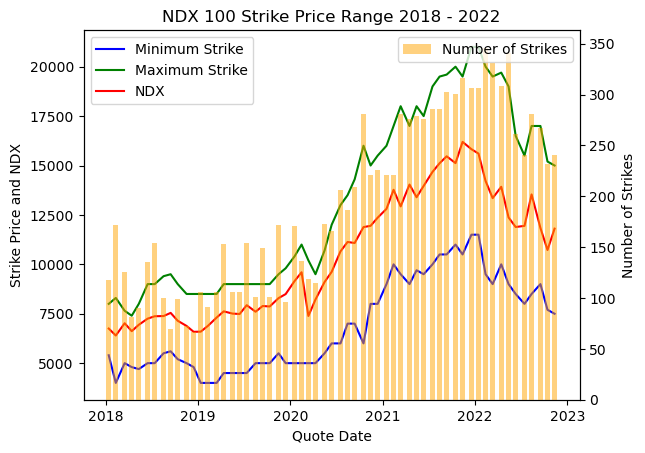

In [11]:
def strike_min(group):
    return group['strike'].min() # smallest strike on a given date

def strike_max(group):
    return group['strike'].max() # largest strike on a given date

def NDX(group):
    return group['implied_S_y'].max() # implied NDX on a given date

def group_length(group):
    return len(group)

fig, ax1 = plt.subplots()
ax1.plot(merged_data_new.groupby("quote_date").apply(strike_min), label="Minimum Strike", color='b')
ax1.plot(merged_data_new.groupby("quote_date").apply(strike_max), label="Maximum Strike", color='g')
ax1.plot(merged_data_new.groupby("quote_date").apply(NDX), label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')
# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_new.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_new.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()


## Strike Selection using multiples of volatility away from underlying

The paper calculates both volatility and monthly returns ex ante because it aims for monthly rebalancing. We are using static weights based on an ex post approach. It is thus sound to use actual realized vol along with mean returns for the entire period for observing optimal weights. However in a backtesting scenario, we would need to forecast realized vol either by GARCH or use Implied Vol.

In [48]:
# get 28-day vol of NDX 100
vols = []
quote_dates = merged_data_new['quote_date'].unique()
expirations = merged_data_new['expiration_C'].unique()
for i in range(len(quote_dates)):
    q = quote_dates[i]
    e = expirations[i]
    NDX = NDX_100[(NDX_100['Date'] >= q) & (NDX_100['Date'] <= e)]
    vols.append(NDX['NDX_Exp'].std())

monthly_vol = pd.DataFrame({'quote_date' : quote_dates, 'vol' : vols})
merged_data_vol = pd.merge(merged_data_new, monthly_vol, on = 'quote_date', how = 'left')
merged_data_vol['adj_strike'] = -merged_data_vol['distance_to_strike']/merged_data_vol['vol']
merged_data_vol

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,vol,adj_strike
0,2018-01-12,2018-02-09,5400.0,1347.00,1368.30,0.05,3.1,2018-01-12,0.0131,6750.221453,1350.221453,6751.233067,199.483861,-6.768575
1,2018-01-12,2018-02-09,5500.0,1248.00,1269.00,0.25,3.7,2018-01-12,0.0131,6750.563054,1250.563054,6751.233067,199.483861,-6.268994
2,2018-01-12,2018-02-09,5600.0,1151.60,1165.90,0.65,4.2,2018-01-12,0.0131,6750.254655,1150.254655,6751.233067,199.483861,-5.766154
3,2018-01-12,2018-02-09,5700.0,1052.40,1066.70,1.70,4.3,2018-01-12,0.0131,6750.371256,1050.371256,6751.233067,199.483861,-5.265445
4,2018-01-12,2018-02-09,5800.0,953.10,967.40,2.40,5.1,2018-01-12,0.0131,6750.212857,950.212857,6751.233067,199.483861,-4.763357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11435,2022-11-11,2022-12-09,14600.0,0.20,2.60,2740.00,2764.7,2022-11-11,0.0371,11804.796038,-2795.203962,11805.333099,167.500778,16.687707
11436,2022-11-11,2022-12-09,14700.0,0.10,2.40,2839.40,2864.2,2022-11-11,0.0371,11804.892928,-2895.107072,11805.333099,167.500778,17.284141
11437,2022-11-11,2022-12-09,14800.0,0.05,2.25,2939.00,2963.8,2022-11-11,0.0371,11804.889819,-2995.110181,11805.333099,167.500778,17.881172
11438,2022-11-11,2022-12-09,14900.0,0.00,2.10,3038.60,3063.3,2022-11-11,0.0371,11804.936710,-3095.063290,11805.333099,167.500778,18.477904


In [49]:
merged_data_vol.shape

(11440, 14)

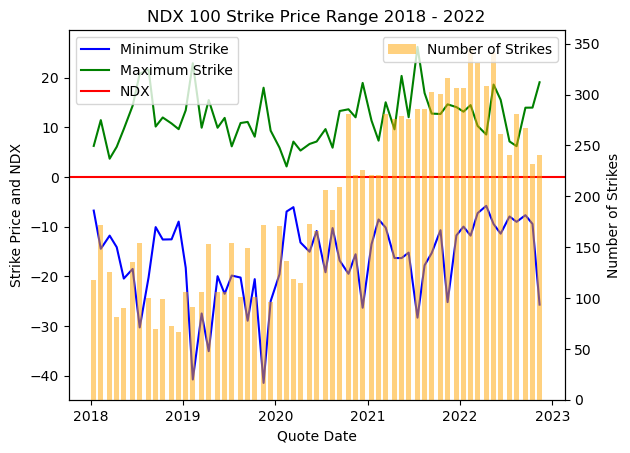

In [13]:
def adj_strike_min(group):
    return group['adj_strike'].min() # smallest adj strike on a given date

def adj_strike_max(group):
    return group['adj_strike'].max() # largest adj strike on a given date

low_bound = merged_data_vol.groupby("quote_date").apply(adj_strike_min)
high_bound = merged_data_vol.groupby("quote_date").apply(adj_strike_max)


fig, ax1 = plt.subplots()
ax1.plot(low_bound, label="Minimum Strike", color='b')
ax1.plot(high_bound, label="Maximum Strike", color='g')
ax1.axhline(0, label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')
# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_vol.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_vol.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("NDX 100 Strike Price Range 2018 - 2022")
plt.show()

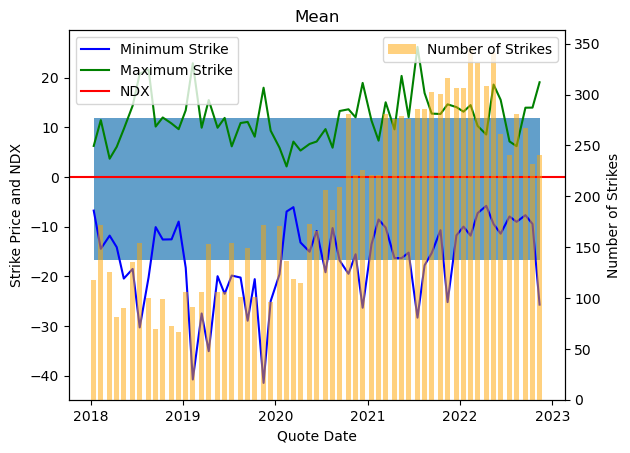

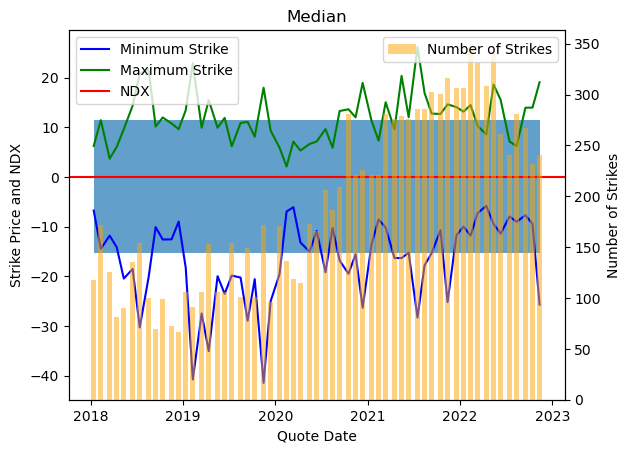

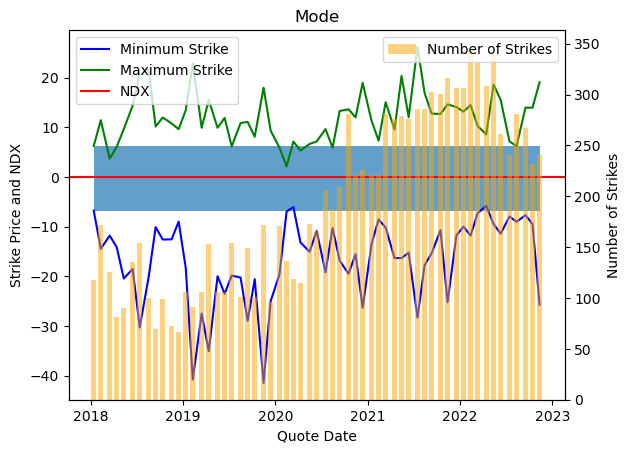

In [14]:
low_bound = merged_data_vol.groupby("quote_date").apply(adj_strike_min)
high_bound = merged_data_vol.groupby("quote_date").apply(adj_strike_max)

low_bound_mean = low_bound.mean()
high_bound_mean = high_bound.mean()

low_bound_median = low_bound.median()
high_bound_median = high_bound.median()

from statistics import mode
low_bound_mode = mode(low_bound)
high_bound_mode = mode(high_bound)

# mean
fig, ax1 = plt.subplots()
ax1.plot(low_bound, label="Minimum Strike", color='b')
ax1.plot(high_bound, label="Maximum Strike", color='g')
ax1.axhline(0, label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')

plt.fill_between(quote_dates, low_bound_mean, high_bound_mean, alpha = 0.7)

# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_vol.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_vol.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("Mean")
plt.show()



# median
fig, ax1 = plt.subplots()
ax1.plot(low_bound, label="Minimum Strike", color='b')
ax1.plot(high_bound, label="Maximum Strike", color='g')
ax1.axhline(0, label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')

plt.fill_between(quote_dates, low_bound_median, high_bound_median, alpha = 0.7)

# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_vol.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_vol.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("Median")
plt.show()



# mode
fig, ax1 = plt.subplots()
ax1.plot(low_bound, label="Minimum Strike", color='b')
ax1.plot(high_bound, label="Maximum Strike", color='g')
ax1.axhline(0, label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')

plt.fill_between(quote_dates, low_bound_mode, high_bound_mode, alpha = 0.7)

# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_vol.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_vol.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("Mode")
plt.show()


In [52]:
low_bound_mean = low_bound.mean()
high_bound_mean = high_bound.mean()


low_bound_median = low_bound.median()
high_bound_median = high_bound.median()


from statistics import mode
low_bound_mode = mode(low_bound)
high_bound_mode = mode(high_bound)


size_mean = merged_data_vol.query("@low_bound_mean <= adj_strike <= @high_bound_mean")
size_median = merged_data_vol.query("@low_bound_median <= adj_strike <= @high_bound_median")
size_mode = merged_data_vol.query("@low_bound_mode <= adj_strike <= @high_bound_mode")

print(f"original size: {merged_data_vol.shape}")
print(f"mean size: {size_mean.shape}")
print(f"median size: {size_median.shape}")
print(f"mode size: {size_mode.shape}")

original size: (11440, 14)
mean size: (10748, 14)
median size: (10571, 14)
mode size: (7543, 14)


Text(0.5, 1.0, 'Bollinger Band')

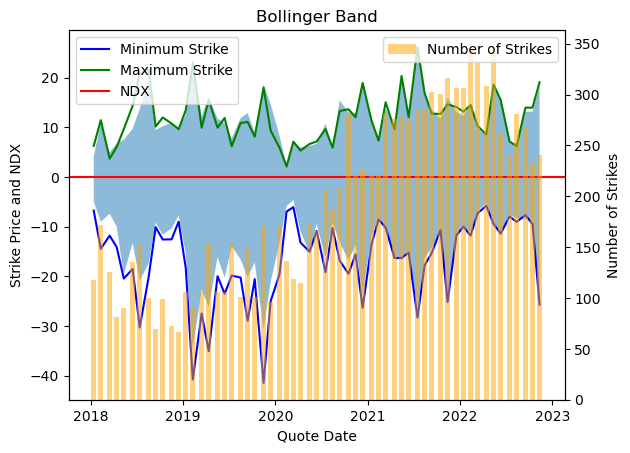

In [53]:
std = merged_data_vol.groupby("quote_date")['adj_strike'].std()
avg = merged_data_vol.groupby("quote_date")['adj_strike'].mean()

# Bollinger Band

fig, ax1 = plt.subplots()
ax1.plot(low_bound, label="Minimum Strike", color='b')
ax1.plot(high_bound, label="Maximum Strike", color='g')
ax1.axhline(0, label="NDX", color='r')
ax1.set_xlabel('Quote Date')
ax1.set_ylabel('Strike Price and NDX', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.legend(loc='upper left')

plt.fill_between(quote_dates, avg + (2 * std),avg - (2 * std), alpha = 0.5)

# Create a secondary y-axis for the bar graph
ax2 = ax1.twinx()
# Plot the bar graph on the secondary y-axis
ax2.bar(merged_data_vol.groupby("quote_date").apply(lambda x: x.name), 
        merged_data_vol.groupby("quote_date").apply(group_length), 
        label="Number of Strikes", color='orange', alpha=0.5, width=20)

ax2.set_ylabel('Number of Strikes', color='k')
ax2.tick_params(axis='y', labelcolor='k')
ax2.legend(loc='upper right')
plt.title("Bollinger Band")

In [65]:
up = avg + (2 * std)
down = avg - (2 * std)

ttest = merged_data_vol.query("@down < adj_strike < @up")
ttest

C:\Users\user\AppData\Local\Temp\ipykernel_5032\3540124759.py:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  ttest = merged_data_vol.query("@down < adj_strike < @up")
C:\Users\user\AppData\Local\Temp\ipykernel_5032\3540124759.py:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  ttest = merged_data_vol.query("@down < adj_strike < @up")
C:\Users\user\AppData\Local\Temp\ipykernel_5032\3540124759.py:4: PerformanceWarning: Alignment difference on axis 0 is larger than an order of magnitude on term '__pd_eval_local_down', by more than 4.058; performance may suffer.
  ttest = merged_data_vol.query("@down < adj_strike < @up")
C:\Users\user\AppData\Local\Temp\ipykernel_5032\3540124759.py:4: PerformanceWarning: Alignment difference on axis 0 is larger than an order of magnitude on term 'adj_strike', by more than 1.771; performanc

,quote_date,expiration_C,strike,bid_1545_C,ask_1545_C,bid_1545_P,ask_1545_P,date,rate,implied_S_x,distance_to_strike,implied_S_y,vol,adj_strike,upper
